# Introduction:
"Pancreatic ducts function to deliver digestive enzymes into the intestines. Upon injury, ducts can become proliferative and contribute to tissue regeneration; however, the identity of the ductal cells that contribute to these processes is unknown. We combined fluorescence-activated cell sorting, a methylcellulose-containing 3-dimensional culture, droplet RNA-sequencing, and a clonal lineage tracing tool to identify and isolate a distinct subpopulation of pancreatic ductal cells that exhibit progenitor cell properties. These ductal cells are unique in that they form tightly-bound clusters (termed FSCmid-high), with an average of 8 cells per cluster. FSCmid-high clusters comprise only about 0.1% of the total pancreas, are tri-potent for duct, acinar and endocrine lineages, and self-renew robustly in vitro. Transcriptomic analysis of FSCmid-high clusters reveals enrichment for genes involved in cell-cell interactions, organ development, and cancer pathways. FSCmid-high clusters express embryonic pancreatic progenitor markers Sox9, Pdx1, and Nkx6-1 at both transcription and protein levels. FSCmid-high clusters are resistant to enzymatic dissociation and survive severe in vivo acinar injury, which induces formation of ductal rosettes that become proliferative within 14 days. Thus, FSCmid-high clusters represent a small subset of ductal cells with progenitor cell properties. These rare progenitor-like duct cell clusters have implications in pancreas regeneration and tumor initiation/progression.

[...]To identify potentially rare adult ductal progenitor cells, here we employed an unbiased fractionation strategy by using fluorescence-activated cell sorting (FACS) on dissociated murine pancreatic cells; we discover a tightly-bound ductal cell cluster (termed FSCmid-high cluster), which constitutes only 0.1% of the total pancreatic cells, as the fundamental progenitor-like cells in the normal adult murine pancreas. The FSCmid-high clusters can self-renew and differentiate in vitro and are resistant to in vivo acinar injury conditions. Our results highlight the highly heterogeneous nature of the adult ductal cells, which may explain the difficulties in studying these rare ductal cells in the past." [1]


Reference: [1]Tremblay et al., “Identification of a Distinct Ductal Subpopulation with Self-Renewal and Differentiation Potential from the Adult Murine Pancreas.”

# Materials:
* Python 3
* scanpy library
* pandas library
* datatable library
* 10XGenomics dataset produced from reference experimental mice


# Methods:
Using Python 3 and the scanpy library, the dataset produced from the 10XGenomics CellRanger will be loaded into a special AnnData object and then processsed for clustering, identification, and other analyses.  The pandas library will be used to sort relevant data from the AnnData.

The goal of the analysis is to identify the distinct cell populations within the FSCmid-high clusters while also looking for any special expression patterns that may help us identify the progenitor cells across the distinct cell types.

To accomplish this, the countdata from the 10XCellRanger will be processed, filtered for quality control, and then PCA will be performed on the dataset so that the cells can be represented in 2 dimensions and then clustered based on the PCA and clutsering algorithms such as the Louvain algorithm which is used in this analysis.

Once the cell types are identified based on their differential expression of hallmark genes such as SST, GCG, and INS1, the ductal cells will then be clustered and compared to the whole dataset to see if the ductal cells have a higher proportion of progenitor cells compared to the other distinct cell types.

## Load 10X Genomics Output into Python Data Frame

In [4]:
import sys
import pandas as pd
import scanpy
import scanpy as sc
import datatable as dt


results_file = 'C:/Users/Kevin/Documents/Summer semester/mpancreas.h5ad'# the file that will store the analysis results
ductal_file = 'C:/Users/Kevin/Documents/Summer semester/mductal.h5ad'
adata = scanpy.read_10x_mtx(
    'C:/Users/Kevin/Documents/Summer semester',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 14822 × 32738
    var: 'gene_ids', 'feature_types'

### This code creates the AnnData object which can then be processed with the scanpy library to add extra annotations for filtering and storage of performed analysis.

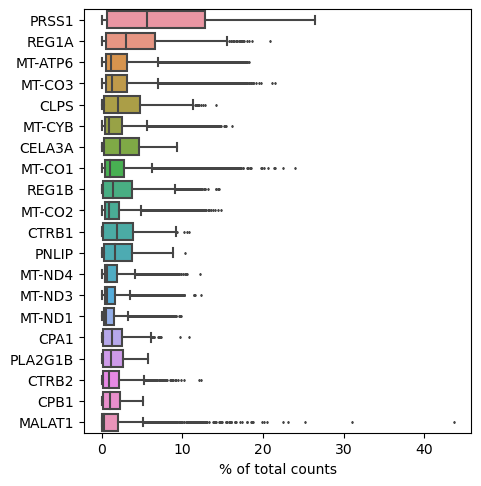

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### A visualization of the highest expressed genes in the dataset based on count proportion, can be informative if you have a very pure isolation of cells before collecting RNA.

## QC

In [6]:
sc.pp.filter_cells(adata, min_genes=200)

Remove cells with gene counts below 200 (outliers which likely do not represent actual cells)

In [7]:
#Filter doublets
#adata = scanpy.external.pp.scrublet(adata)
#adata = adata[adata.obs.predicted_doublet == False]

Code which performs doublet prediction via the scrublet library callable within the scanpy object.  Annotation is added under "predicted_doublet" column.  Doublet removal was not used in the QC for this dataset

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.pct_counts_mt < 15, :]

Annotation of mitochondrial genes which begin with "MT-" via gene naming convention.  Cells with high % of mitochondrial gene count are considered low quality as mitochondrial genes are not from the nucleus and are not the focus of this study.  We will be filtering any cells that have more than 15% mitochondrial genes by total count.

C:\Users\Kevin\anaconda3\lib\site-packages\anndata\_core\anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


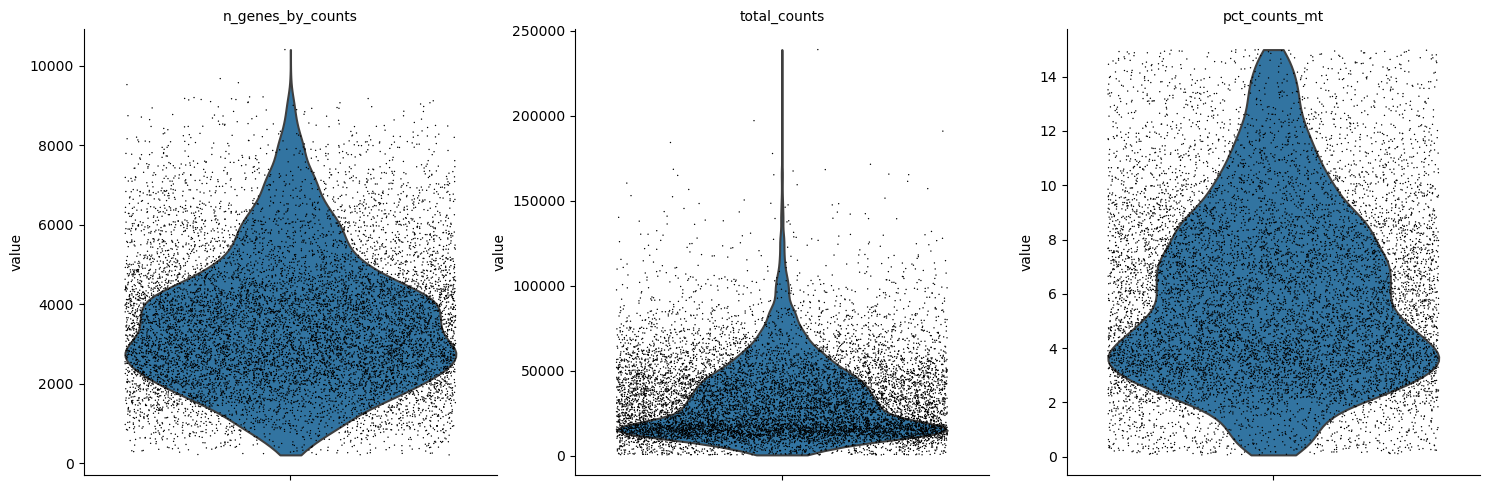

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

### Violin plot of the quality metrics we will be using to filter the data.  Number of genes counted, total counts, and percentage of mitochondrial counts are shown

In [10]:
#Remove genes with too many genes_by_counts and mt>15
adata_5kcount = adata[adata.obs.n_genes_by_counts < 5000, :]
adata.layers['raw_counts'] = adata.X.copy()

Genes with counts above 5000 will be considered an outlier which may skew the results of our analysis and will be filtered

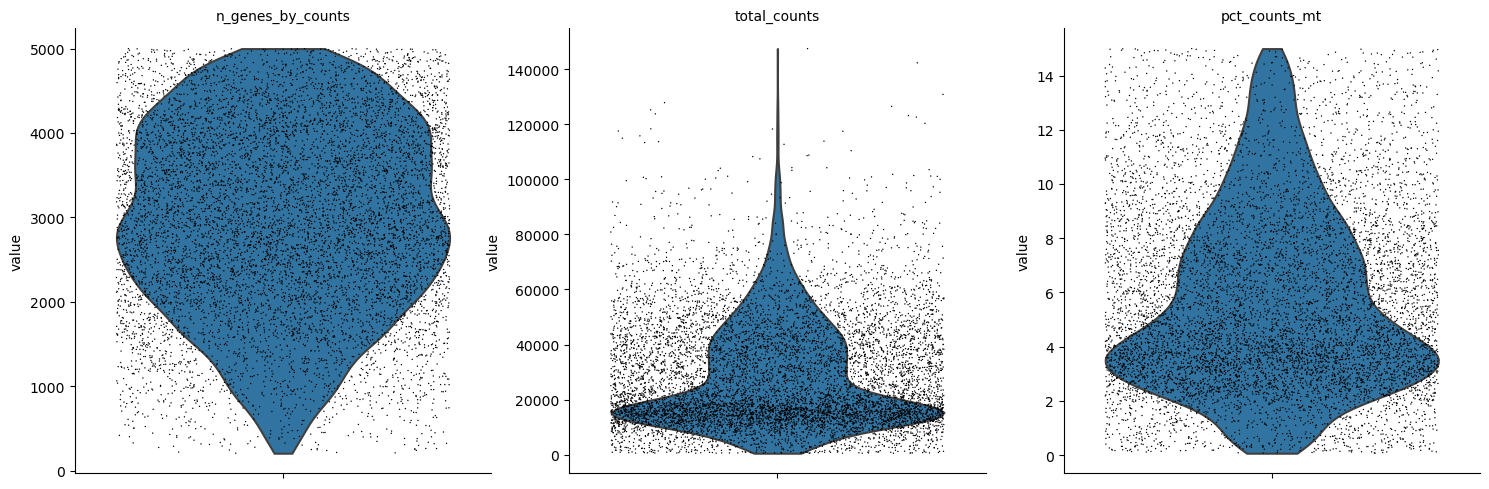

In [11]:
sc.pl.violin(adata_5kcount, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

### Quality metrics after filtering.  See total count reduction from 2500000 to 140000

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor = "seurat")

Data will now be normalized to 10,000 counts per gene so that gene counts can be more easily compared.  After normalization, data will be logarithmized to bring the values closer so the scale of the data can be more easily captured.  Genes with high variation in their counts will be annotated as "highly_variable_genes" via the normalized dispersion.  The normalized dispersion is obtained by scaling with the mean and standard deviation of the dispersions for genes falling into a given bin for mean expression of genes. This means that for each bin of mean expression, highly variable genes are selected.

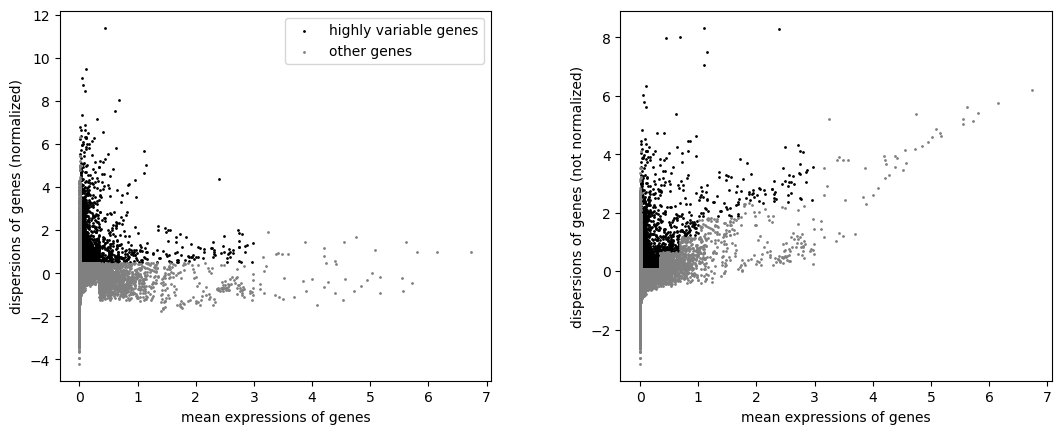

In [13]:
sc.pl.highly_variable_genes(adata)
adata.raw = adata
#save differential gene expression in .raw object for UMAP analysis

### Figures showing the dispersion of the highly variable genes(black) compared to the normal genes(grey).  Note how the dispersion increases as the gene expression is reduced 

In [14]:
#adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

Highly variable data within the total_counts and pct_counts_mt columns will be regressed out.
The data will also be scaled so that the means of each gene is 0.  This is necessary for Principle Component Analysis(PCA).  High outliers above 10 will be removed.

## Clustering (PC Analysis)

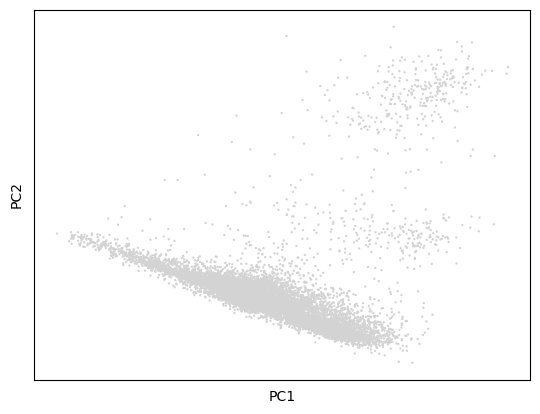

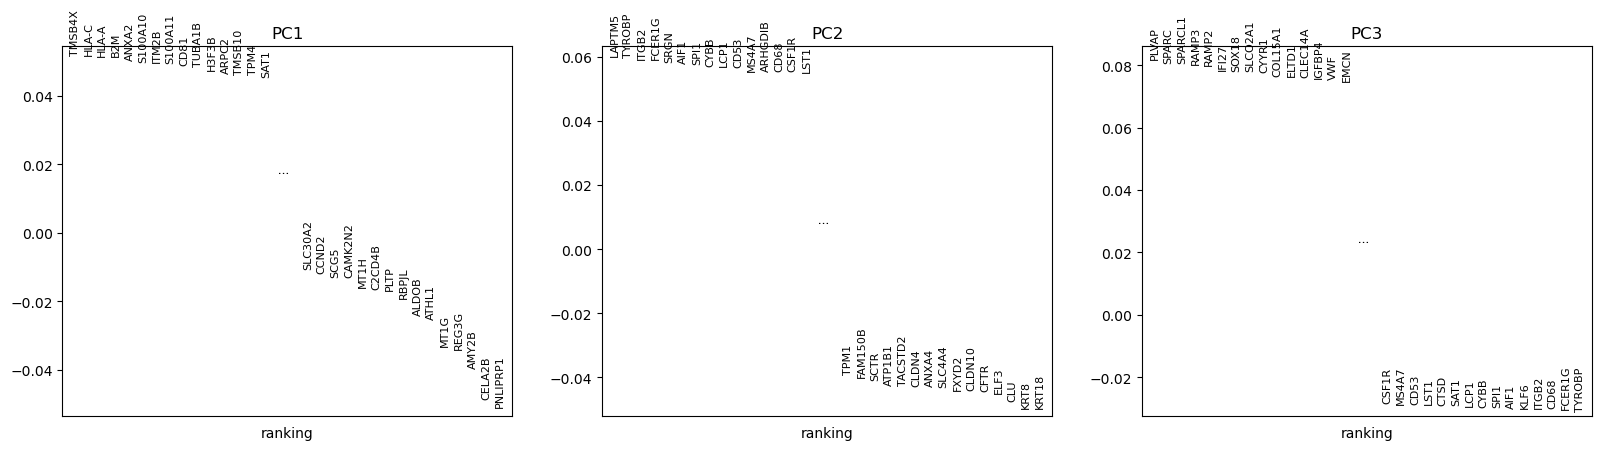

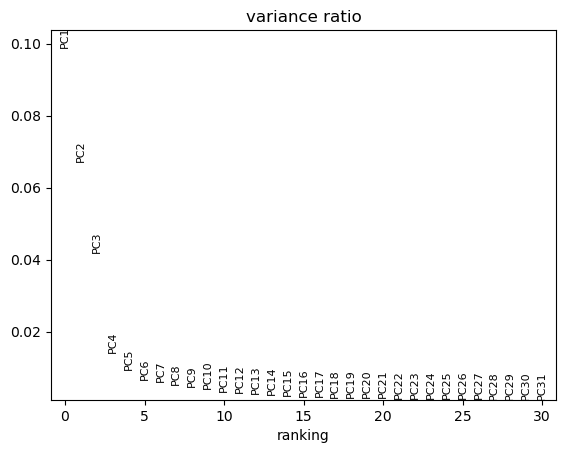

In [15]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_overview(adata)  # plot the pca results
#no equivalent to Seurat elbow plot in scanpy

Scanpy algorithm "arpack" is used to perform PCA on the dataset so we can identify the optimal number of principle components to capture most of the variation in the data while still reducing the dimentionality of it.

### Resulting graphs show the analysis across 2 and 3 PCs and the genes which contribute the majority of the variance to each PC.  Final graph shows the amount of variance captured from each PC, with a majority of the variance being captued by PC14.

In [16]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=14)

Calculate neighbor graph using scanpy neighbors function [2] 
(Ref: [2]McInnes & Healy (2018), UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, arXiv.)

In [17]:
sc.tl.louvain(adata, resolution = 0.8)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

Perform initial clustering using louvain algorithm on dataset.  Neighborhood graph and clustering information is then annotated to data as paga.

C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


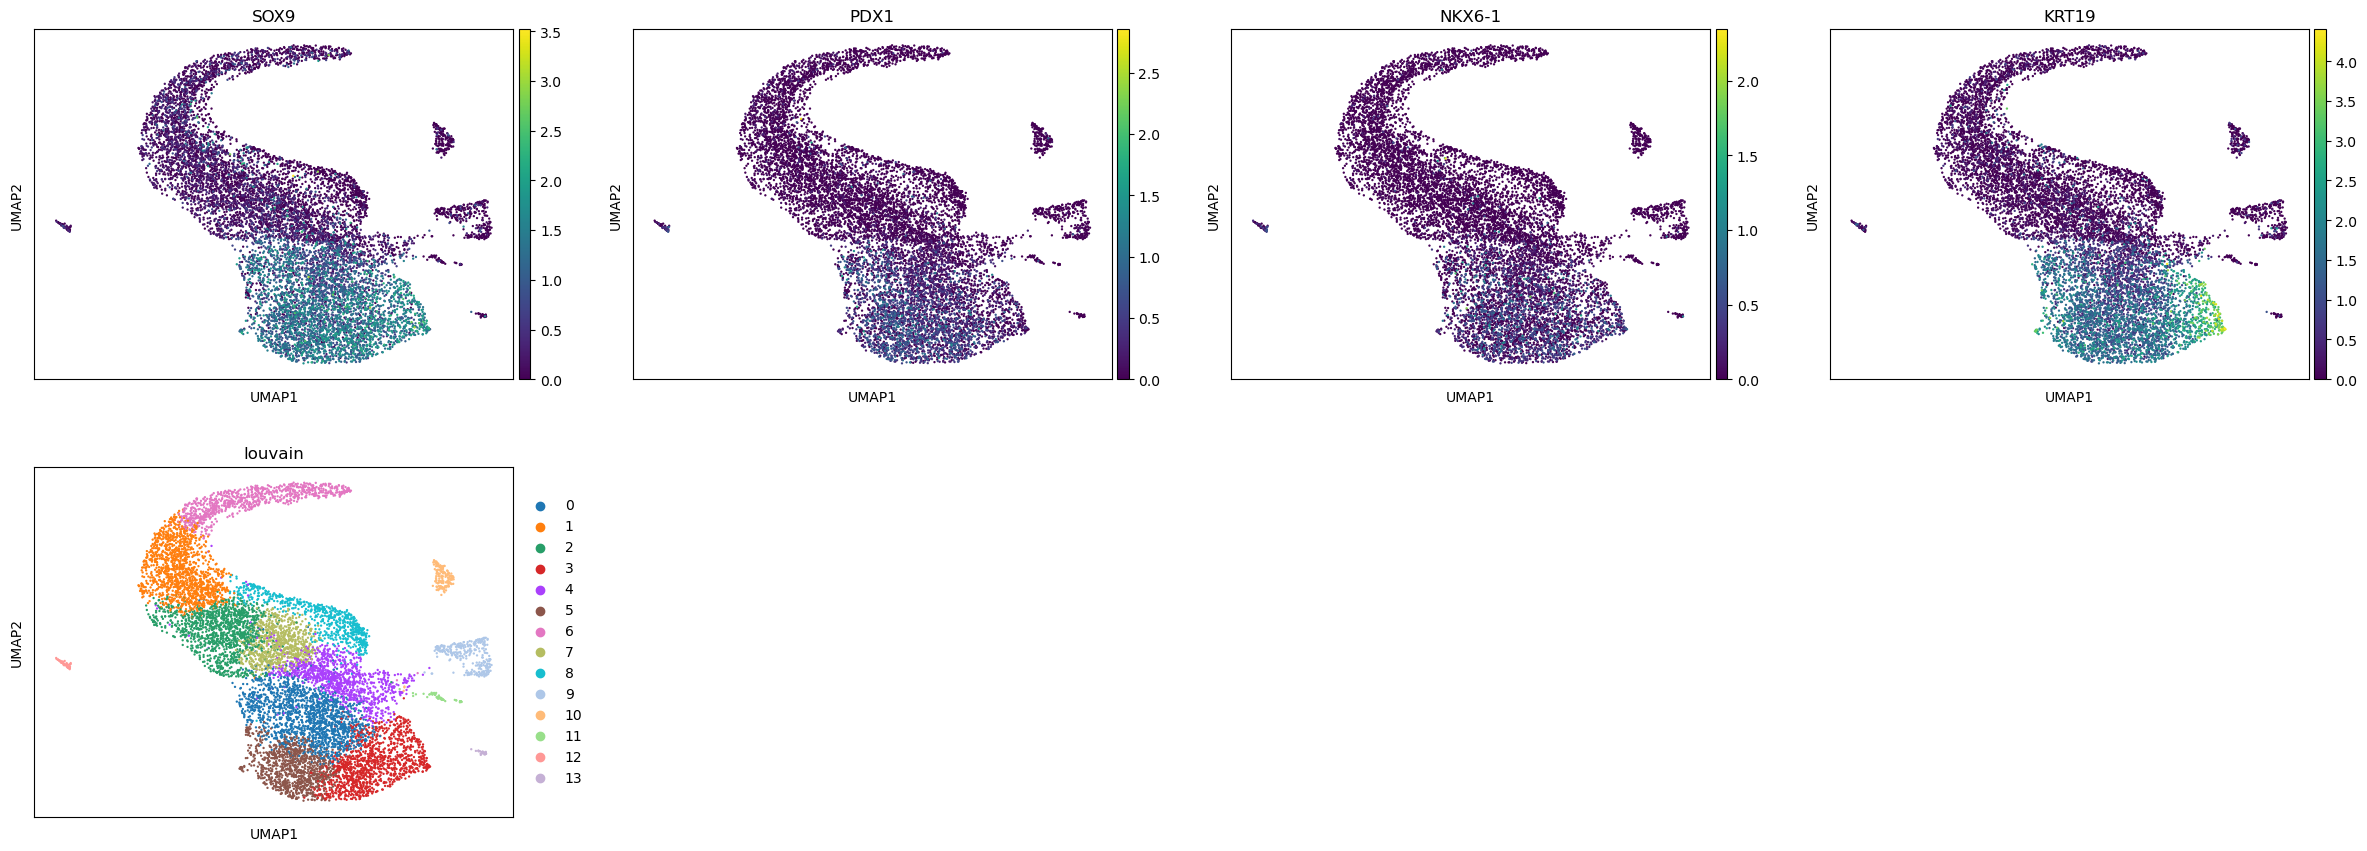

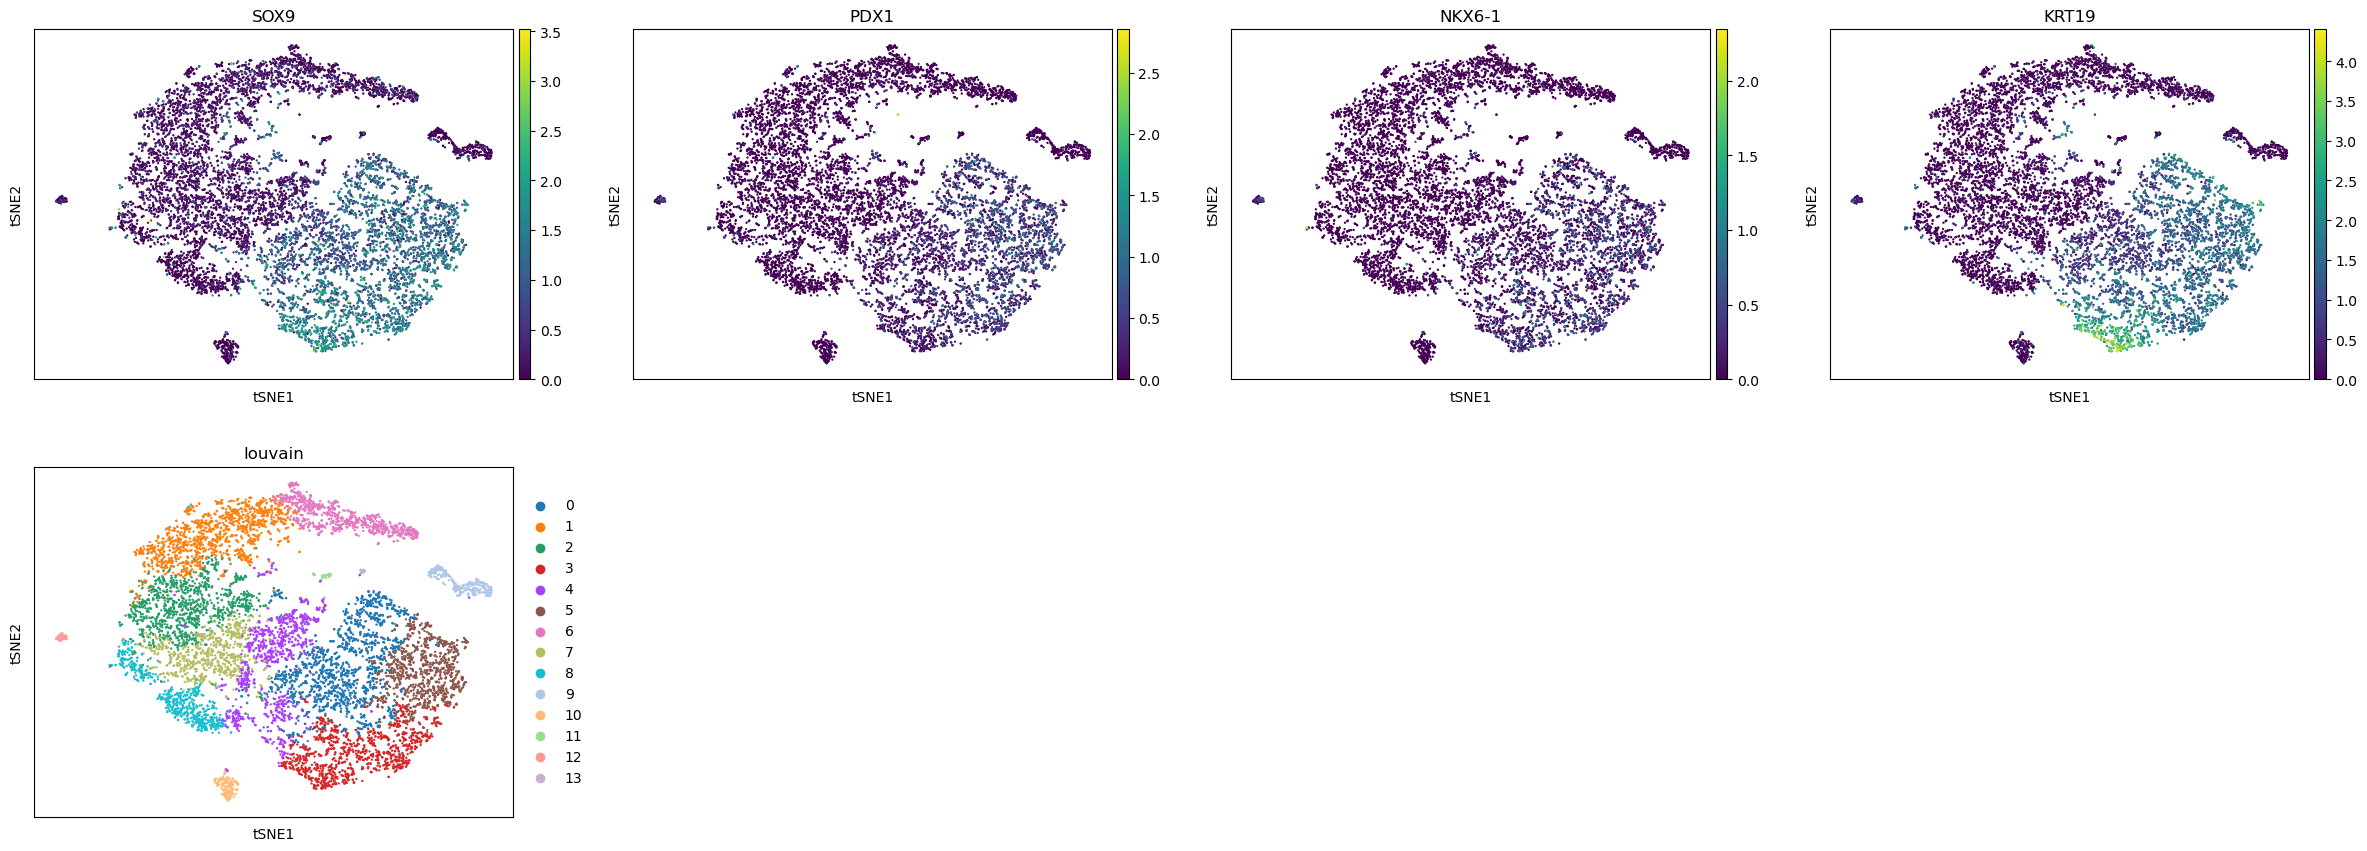

In [18]:
sc.tl.umap(adata, init_pos='paga')
sc.tl.tsne(adata, n_pcs=14, learning_rate=200)
sc.pl.umap(adata, color=["SOX9", "PDX1", "NKX6-1","KRT19", "louvain"])
sc.pl.tsne(adata, color=["SOX9", "PDX1", "NKX6-1", "KRT19", "louvain"])

Unifold Manifold Approximation and Projection as well as t-stochastic Neighborhood Embedding are performed on the dataset using the correlated scanpy functions.
After the UMAP and tsNE data is annotated to the AnnData, the results can be plotted with grouping by gene of interest and clustering results to highlight the location of the cells or clusters of interest relative to the entire dataset.

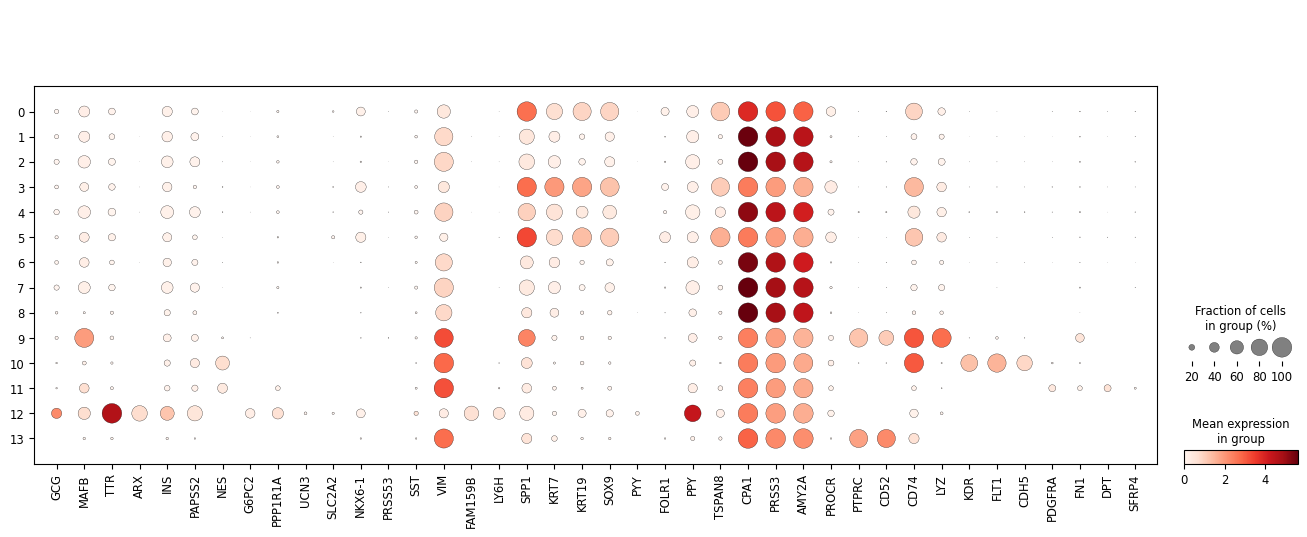

In [19]:
adata
genes = ["GCG", "MAFB", "TTR", "ARX", "INS", "PAPSS2", "NES", "G6PC2", "PPP1R1A", "UCN3", "SLC2A2", "NKX6-1", "PRSS53", "SST", "VIM", "FAM159B", "LY6H", "SPP1", "KRT7", "KRT19", "SOX9", "PYY", "FOLR1", "PPY", "TSPAN8", "CPA1", "PRSS3", "AMY2A", "PROCR", "PTPRC", "CD52", "CD74", "LYZ", "KDR", "FLT1", "CDH5", "PDGFRA", "FN1", "DPT", "SFRP4"]
sc.pl.dotplot(adata, genes, groupby = 'louvain')

### Dotplot of marker genes is used to identify distinct cell types identified within each cluster.  Clusters which end up identifying the same cell type will be combined.

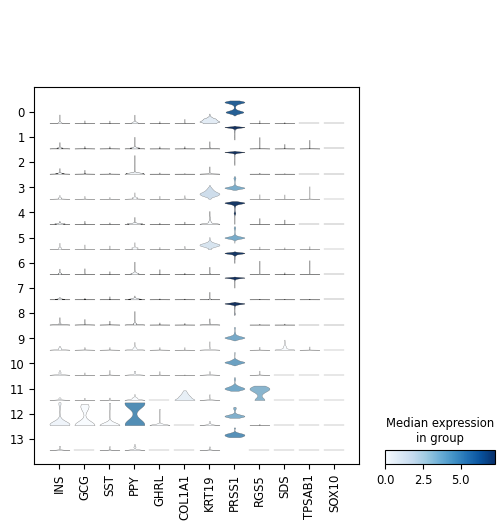

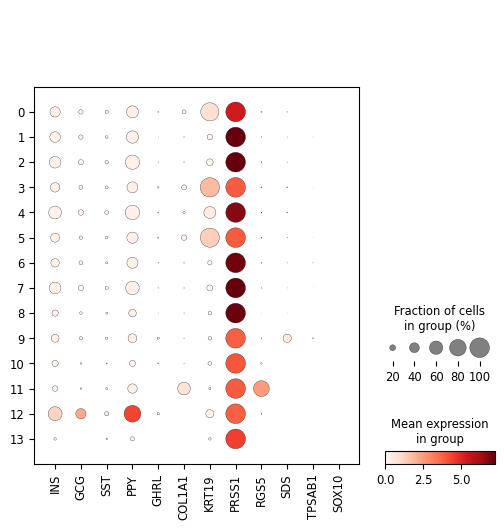

In [20]:
sc.pl.stacked_violin(adata, ["INS","GCG","SST","PPY","GHRL","COL1A1","KRT19","PRSS1","RGS5","SDS","TPSAB1","SOX10"], groupby = 'louvain')
sc.pl.dotplot(adata, ["INS","GCG","SST","PPY","GHRL","COL1A1","KRT19","PRSS1","RGS5","SDS","TPSAB1","SOX10"], groupby = 'louvain')

### Other marker gene comparison for finding pancreas stellate cells (COL1A1 and RGS5)

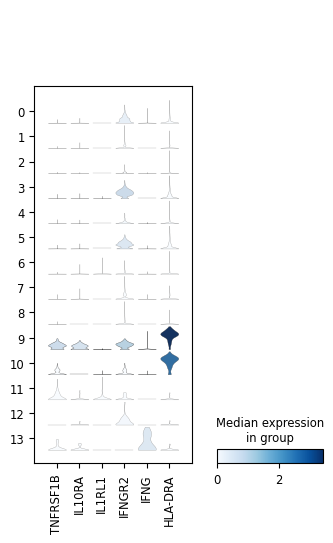

In [21]:
sc.pl.stacked_violin(adata, ["TNFRSF1B", "IL10RA", "IL1RL1", "IFNGR2", "IFNG", "HLA-DRA"], groupby = 'louvain')

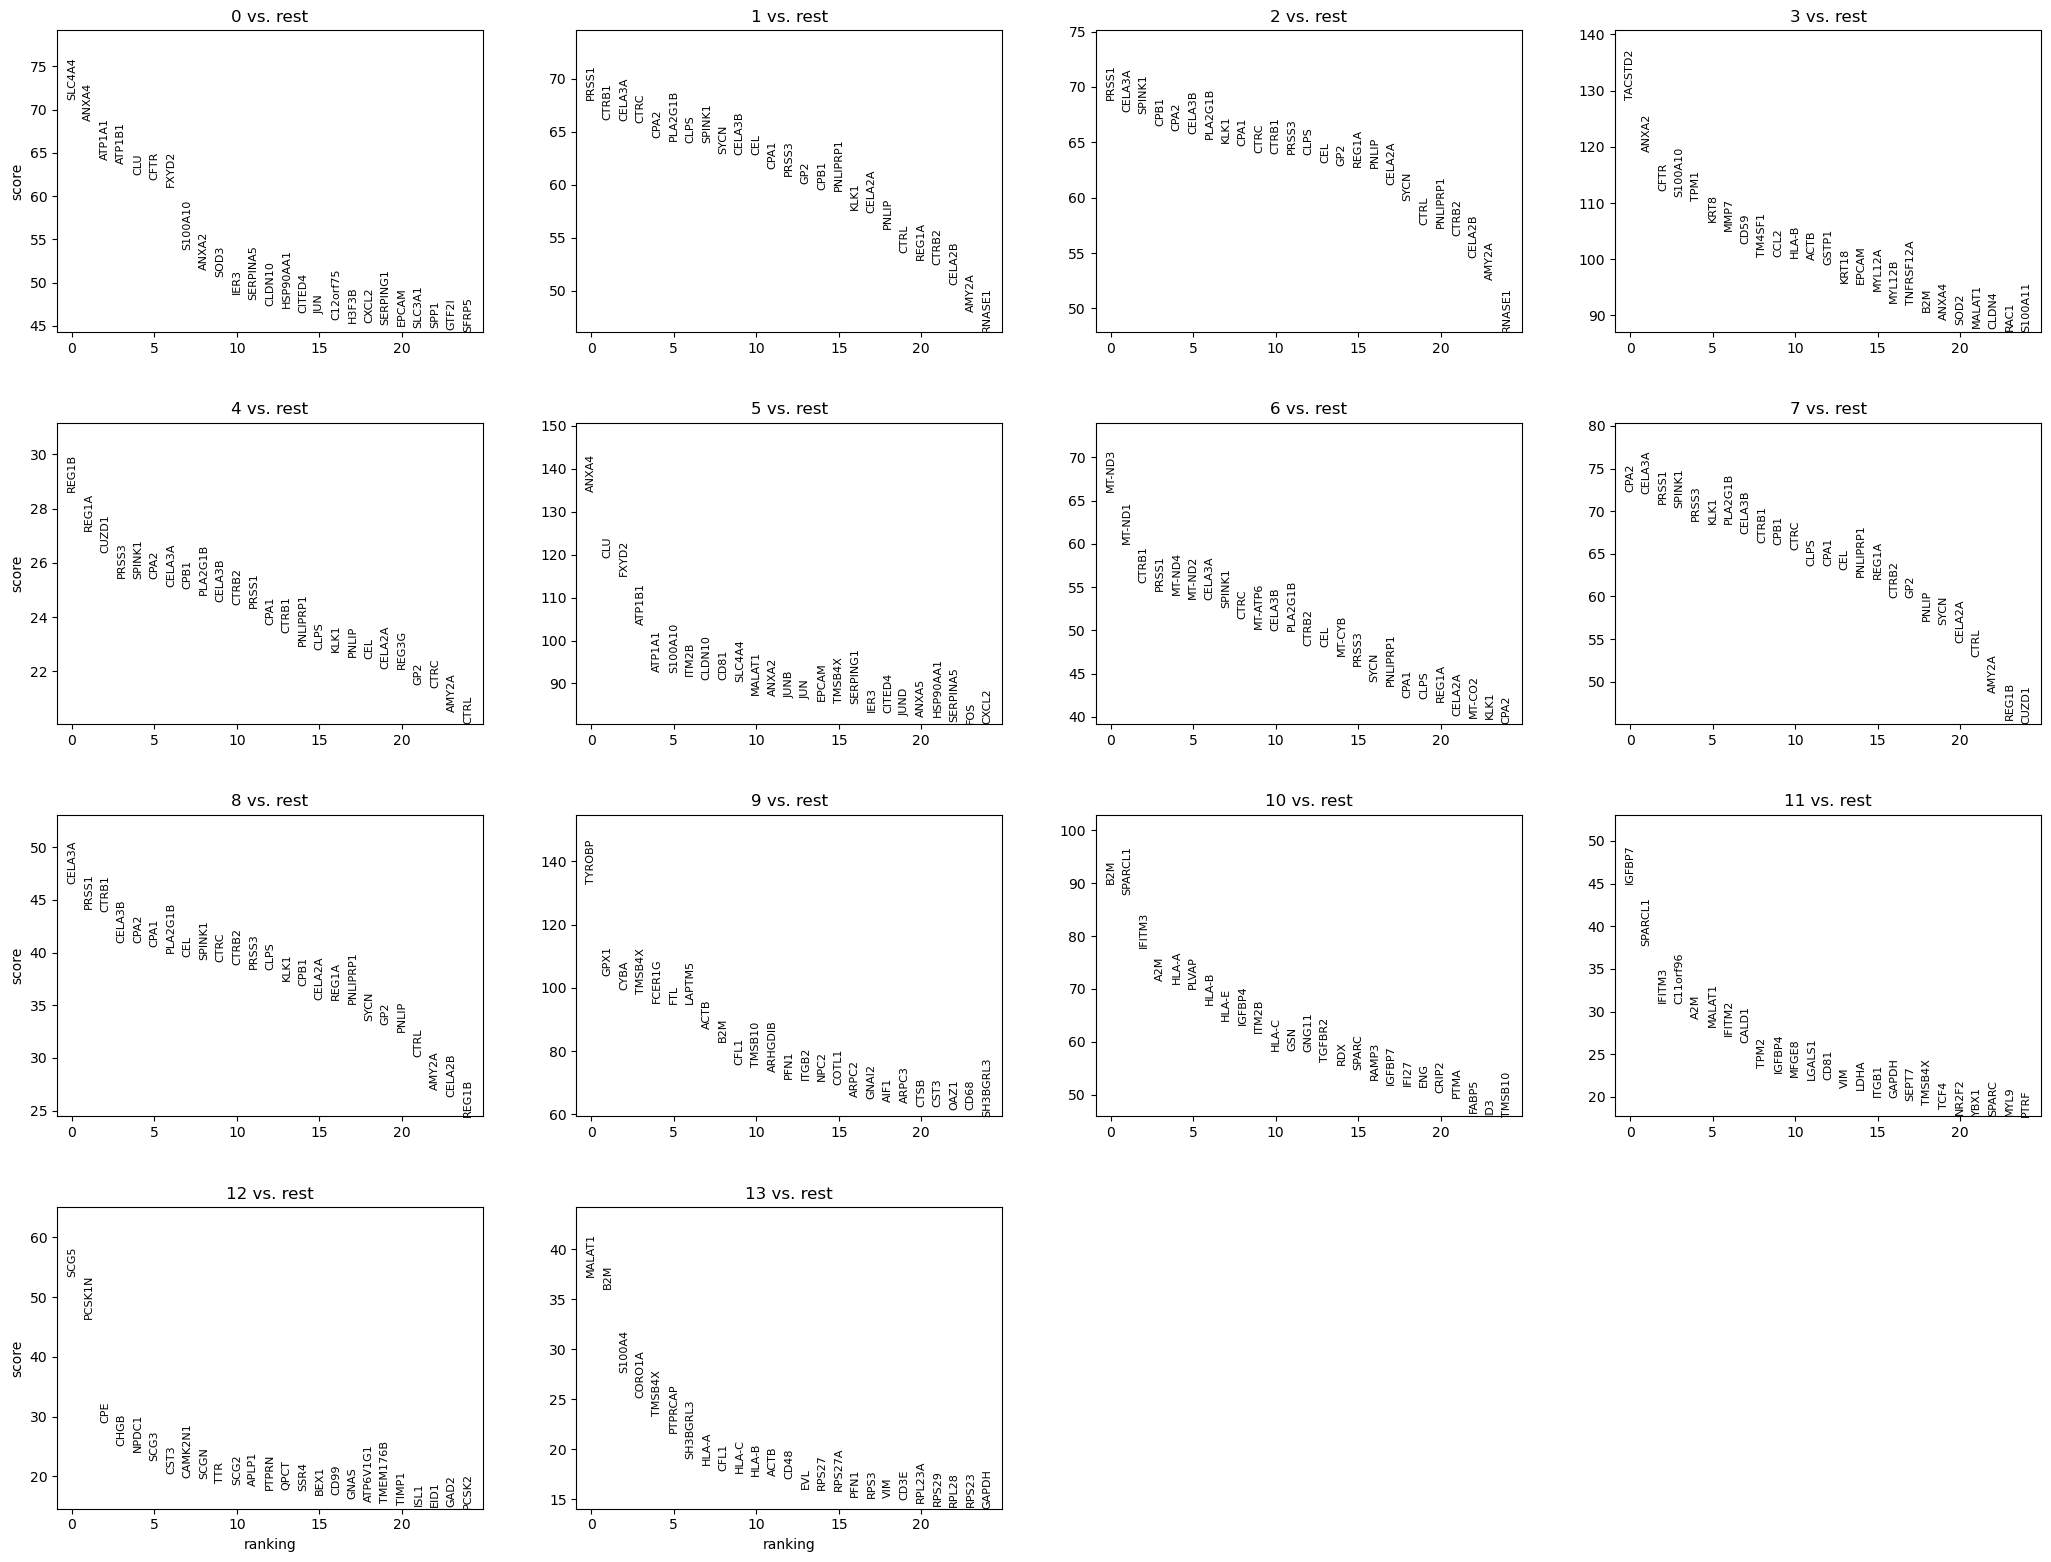

In [22]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Comparison of each cluster to all other clusters using t-test to determine significantly expressed genes.  Plot shows the top 15 differentially expressed genes.

In [23]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(15)

0_n  0_p      1_n  1_p      2_n  2_p      3_n  3_p       4_n  \
0     SLC4A4  0.0    PRSS1  0.0    PRSS1  0.0  TACSTD2  0.0     REG1B   
1      ANXA4  0.0    CTRB1  0.0   CELA3A  0.0    ANXA2  0.0     REG1A   
2     ATP1A1  0.0   CELA3A  0.0   SPINK1  0.0     CFTR  0.0     CUZD1   
3     ATP1B1  0.0     CTRC  0.0     CPB1  0.0  S100A10  0.0     PRSS3   
4        CLU  0.0     CPA2  0.0     CPA2  0.0     TPM1  0.0    SPINK1   
5       CFTR  0.0  PLA2G1B  0.0   CELA3B  0.0     KRT8  0.0      CPA2   
6      FXYD2  0.0     CLPS  0.0  PLA2G1B  0.0     MMP7  0.0    CELA3A   
7    S100A10  0.0   SPINK1  0.0     KLK1  0.0     CD59  0.0      CPB1   
8      ANXA2  0.0     SYCN  0.0     CPA1  0.0   TM4SF1  0.0   PLA2G1B   
9       SOD3  0.0   CELA3B  0.0     CTRC  0.0     CCL2  0.0    CELA3B   
10      IER3  0.0      CEL  0.0    CTRB1  0.0    HLA-B  0.0     CTRB2   
11  SERPINA5  0.0     CPA1  0.0    PRSS3  0.0     ACTB  0.0     PRSS1   
12    CLDN10  0.0    PRSS3  0.0     CLPS  0.0    GSTP1  0.0      CPA1   
13  HSP90AA1  0.0      GP2  0.0      CEL  0.0    KRT18  0.0     CTRB1   
14    CITED4  0.0     CPB1  0.0      GP2  0.0    EPCAM  0.0  PNLIPRP1   

              4_p  ...      9_n            9_p     10_n           10_p  \
0   5.734311e-146  ...   TYROBP  2.703758e-276      B2M  3.947361e-184   
1   2.146229e-135  ...     GPX1  5.397597e-258  SPARCL1  7.401888e-144   
2   1.633143e-126  ...     CYBA  6.387497e-263   IFITM3  3.445354e-152   
3   4.262168e-122  ...   TMSB4X   0.000000e+00      A2M  4.261868e-129   
4   2.739931e-122  ...   FCER1G  6.069360e-232    HLA-A  1.387573e-145   
5   8.685774e-122  ...      FTL  1.164695e-241    PLVAP  6.518530e-127   
6   2.872785e-120  ...   LAPTM5  2.150965e-231    HLA-B  3.743037e-146   
7   4.400241e-119  ...     ACTB  4.320044e-290    HLA-E  3.315940e-126   
8   2.607483e-117  ...      B2M  5.300953e-287   IGFBP4  3.743524e-120   
9   3.617048e-115  ...     CFL1  1.030134e-241    ITM2B  1.509776e-129   
10  7.635617e-114  ...   TMSB10  1.284597e-241    HLA-C  1.442266e-127   
11  9.152129e-114  ...  ARHGDIB  1.013745e-199      GSN  2.407078e-115   
12  1.983730e-108  ...     PFN1  2.408533e-215    GNG11  9.817982e-115   
13  7.407173e-107  ...    ITGB2  1.026385e-193   TGFBR2  7.899012e-112   
14  5.698402e-102  ...     NPC2  1.006590e-197      RDX  9.416964e-112   

        11_n          11_p     12_n          12_p      13_n          13_p  
0     IGFBP7  6.564100e-48     SCG5  1.174603e-46    MALAT1  1.943664e-29  
1    SPARCL1  1.214205e-42   PCSK1N  2.404948e-43       B2M  3.330522e-27  
2     IFITM3  8.234185e-39      CPE  2.106808e-33    S100A4  5.555723e-23  
3   C11orf96  8.591157e-38     CHGB  2.361674e-30    CORO1A  9.311997e-22  
4        A2M  1.922065e-36    NPDC1  1.384095e-29    TMSB4X  3.147587e-21  
5     MALAT1  2.151103e-37     SCG3  3.021486e-28   PTPRCAP  7.353967e-20  
6     IFITM2  3.306579e-35     CST3  1.601054e-26  SH3BGRL3  2.418490e-18  
7      CALD1  3.896030e-34  CAMK2N1  1.613763e-25     HLA-A  3.931782e-18  
8       TPM2  2.989720e-31     SCGN  1.991254e-25      CFL1  9.950866e-18  
9     IGFBP4  1.187235e-30      TTR  9.976326e-25     HLA-C  1.404469e-17  
10     MFGE8  3.820922e-30     SCG2  2.663503e-24     HLA-B  1.986090e-17  
11    LGALS1  6.563532e-30    APLP1  3.694952e-24      ACTB  2.075742e-17  
12      CD81  1.245692e-30    PTPRN  1.816142e-23      CD48  6.155074e-17  
13       VIM  6.161334e-29     QPCT  2.245012e-23       EVL  3.177806e-16  
14      LDHA  9.024717e-29     SSR4  2.103617e-23     RPS27  3.292059e-16  

[15 rows x 28 columns]

Grouping of data using pandas to pull the top 15 genes and their associated p-values from the anndata object.

In [24]:
new_cluster_names = ["ductal", "acinar1", "acinar2", "ductal1", "acinar/ductal", "ductal2", "acinar3", "acinar4", "acinar5", "immune1", "endothelial","pancreas stellate", "endocrine", "immune2"]
adata.rename_categories('louvain', new_cluster_names)

Using expression data available, clusters are redefined based on their cell type assumed from marker gene expression.

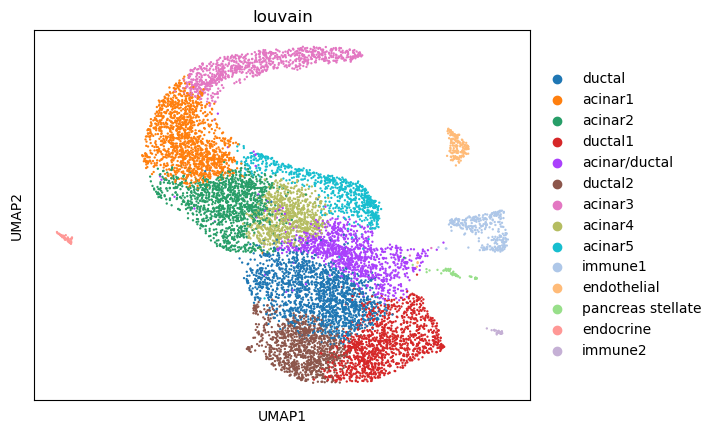

In [25]:
sc.pl.umap(adata, color=["louvain"])

## UMAP Projection of newly labeled clusters

In [26]:
adata.obs['new_clusters'] = (
    adata.obs["louvain"]
    .map(lambda x: {"ductal1": "ductal", "ductal2": "ductal", "acinar1": "acinar", "acinar2": "acinar", "acinar3": "acinar", "acinar4": "acinar", "acinar5": "acinar", "acinar6": "acinar"}.get(x, x))
    .astype("category")
)

Combining of similarly identified clusters for simplification when visualizing.

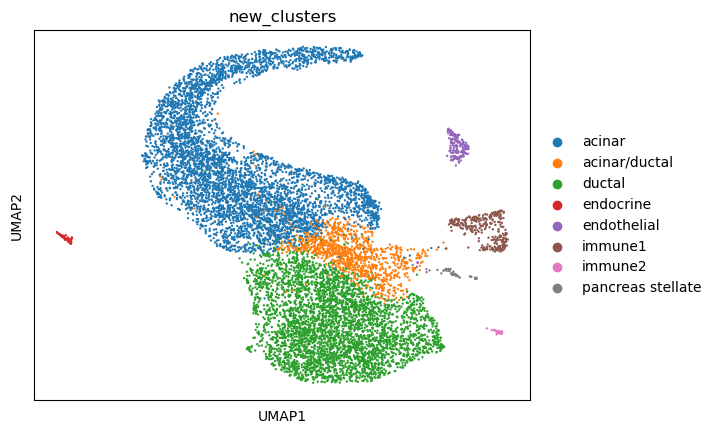

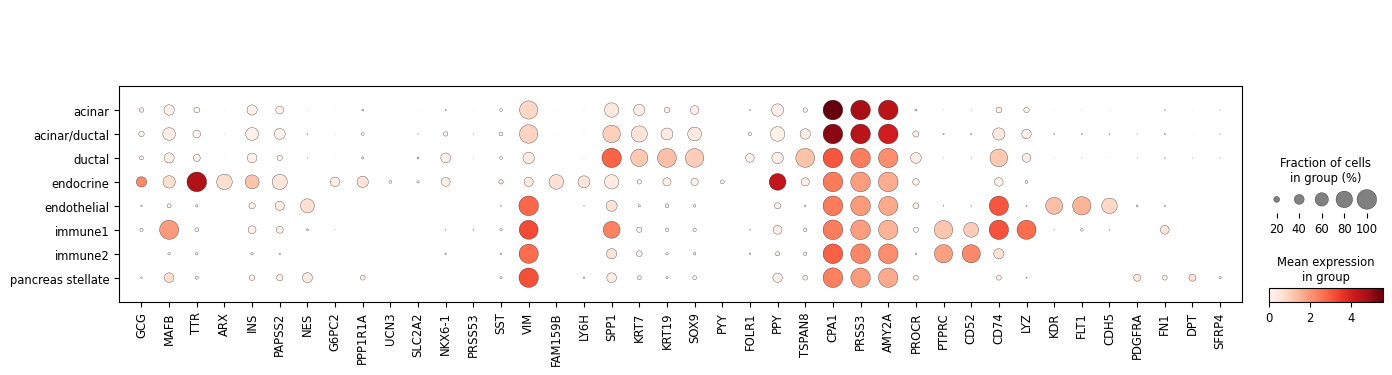

In [27]:
sc.pl.umap(adata, color=["new_clusters"])
sc.pl.dotplot(adata, genes, groupby = 'new_clusters')

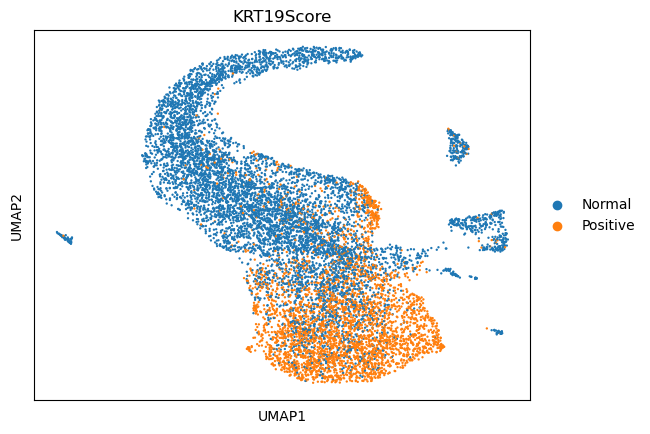

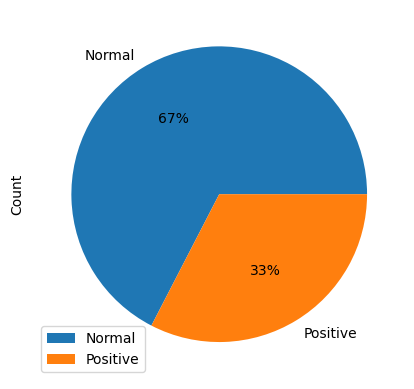

In [30]:
krt19 = sc.get.obs_df(adata, keys='KRT19')
krt19_pos = krt19[krt19>0.1]
krt19_pass = krt19_pos.index.tolist()
adata.obs['KRT19Score'] = 'Normal'
adata.obs.loc[krt19_pass, 'KRT19Score'] = 'Positive'

sc.pl.umap(adata, color=["KRT19Score"])
category = adata.obs['KRT19Score'].value_counts()
krt19df = pd.DataFrame({'Category': category.index, 'Count': category.values})
krt19df.plot.pie(y='Count', labels=krt19df['Category'], autopct='%1.0f%%')

krt_subset = adata[adata.obs['KRT19Score'] == 'Positive']

C:\Users\Kevin\anaconda3\lib\site-packages\scanpy\tools\_louvain.py:217: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


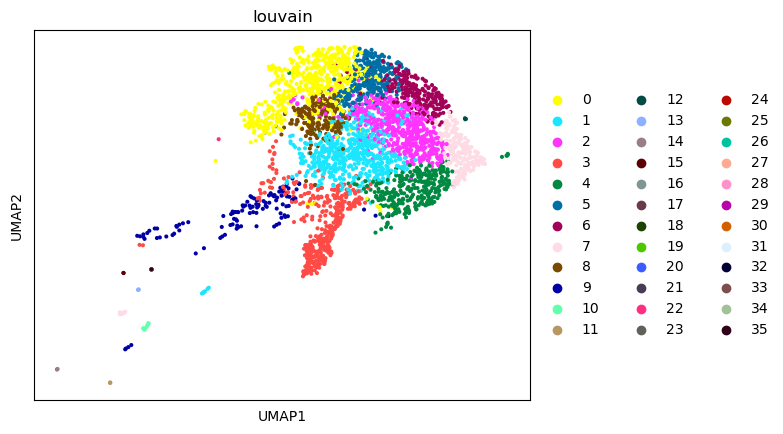

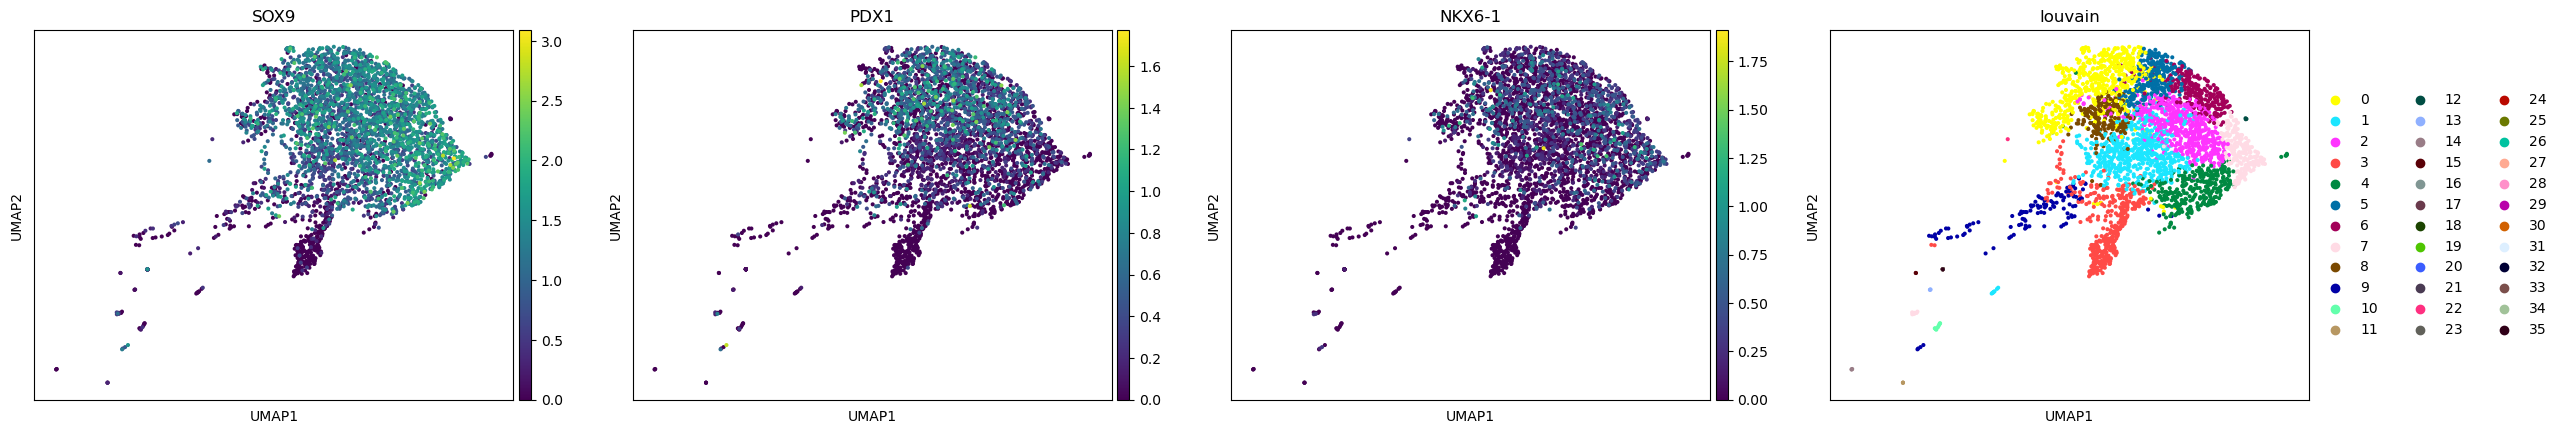

In [31]:
sc.tl.louvain(krt_subset , resolution = 0.8)
sc.tl.umap(krt_subset)
sc.pl.umap(krt_subset, color=["louvain"])
sc.pl.umap(krt_subset, color=["SOX9", "PDX1", "NKX6-1", "louvain"])

In [34]:
TP_marker = ["SOX9","PDX1","NKX6-1"]
clusters = [adata, krt_subset]
for x in clusters: 
    sc.tl.score_genes(x, TP_marker)
    tp_score = sc.get.obs_df(x, keys='score')
    high_scoring = tp_score[tp_score > 0.1]
    passing = high_scoring.index.tolist()
    x.obs['triple_positive'] = 'Normal'
    x.obs.loc[passing, 'triple_positive'] = 'TP'

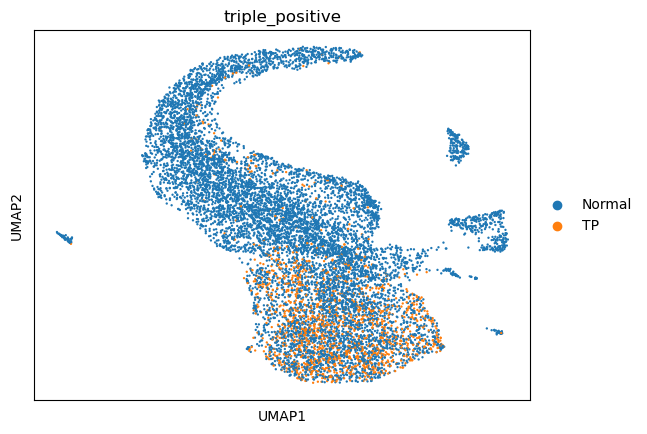

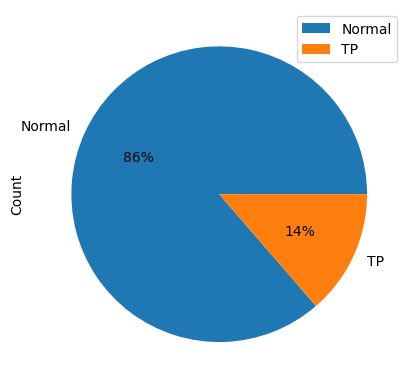

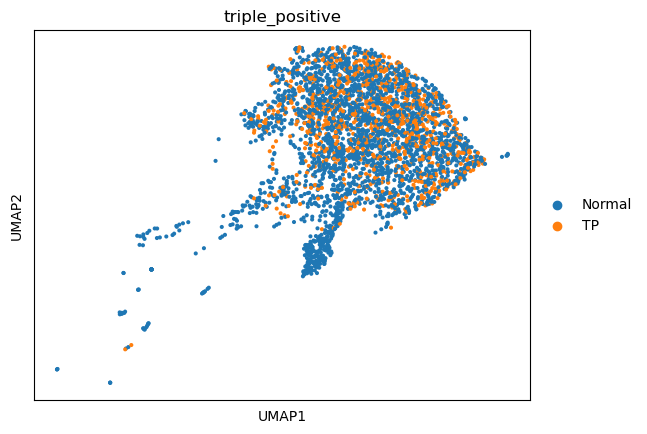

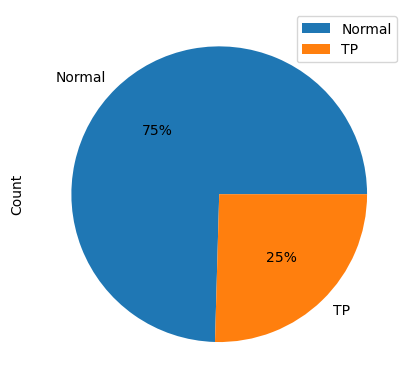

In [35]:
for x in clusters:
    sc.pl.umap(x, color=["triple_positive"])
    category_counts = x.obs['triple_positive'].value_counts()
    dataframe = pd.DataFrame({'Category': category_counts.index, 'Count': category_counts.values})
    dataframe.plot.pie(y='Count', labels=dataframe['Category'], autopct='%1.0f%%')

Dotplot with new clusters

In [36]:
ductal_cells = adata[adata.obs['new_clusters'] == 'ductal'].copy()

Ductal cells are subset from anndata using new_clusters annotations.

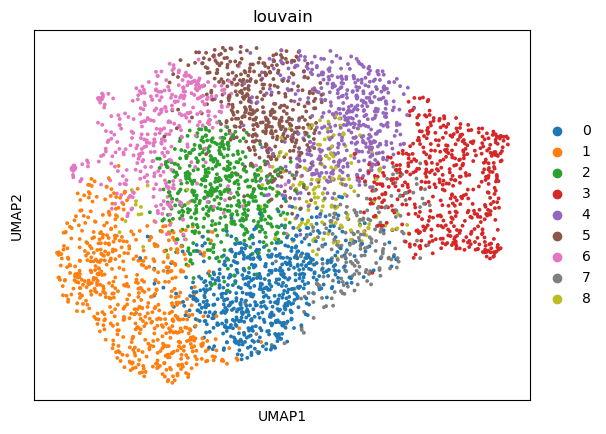

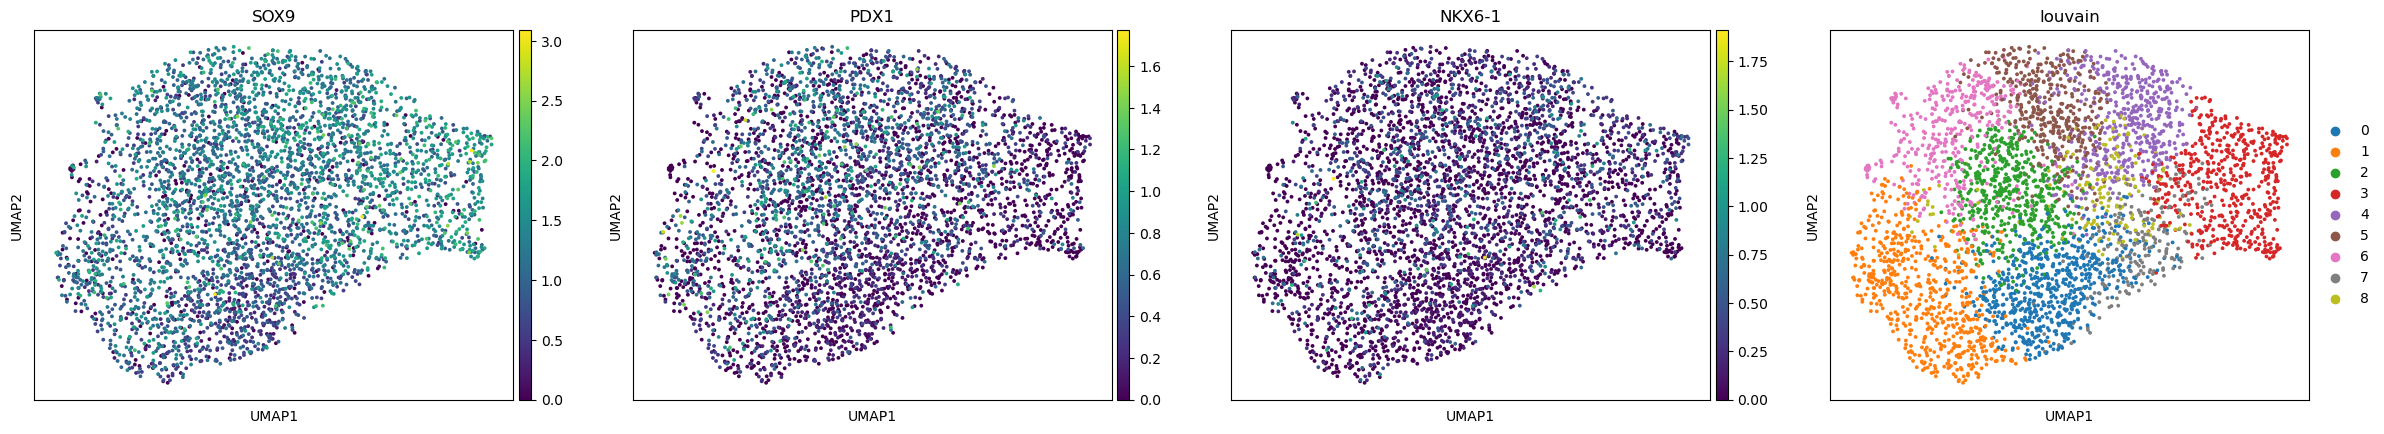

In [37]:
sc.tl.louvain(ductal_cells , resolution = 0.8)
sc.tl.umap(ductal_cells)
sc.pl.umap(ductal_cells, color=["louvain"])
sc.pl.umap(ductal_cells, color=["SOX9", "PDX1", "NKX6-1", "louvain"])

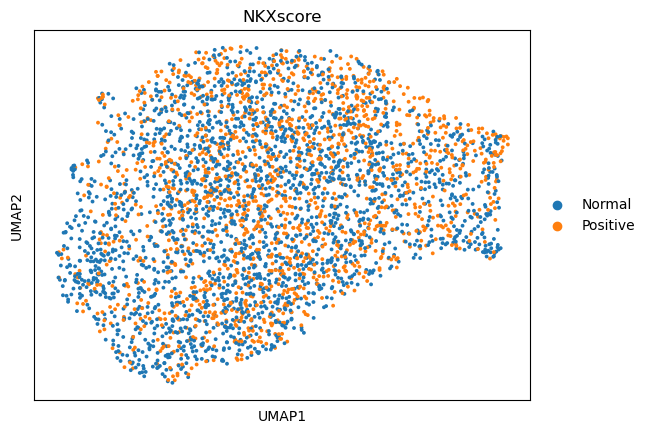

<AxesSubplot:ylabel='Count'>

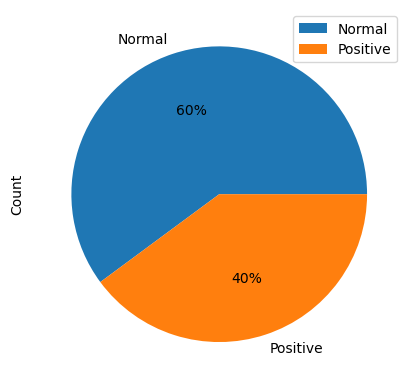

In [38]:
nkx_cells = sc.get.obs_df(ductal_cells, keys='NKX6-1')
nkx_pos = nkx_cells[nkx_cells>0.0]
nkx_passing = nkx_pos.index.tolist()
ductal_cells.obs['NKXscore'] = 'Normal'
ductal_cells.obs.loc[nkx_passing, 'NKXscore'] = 'Positive'

sc.pl.umap(ductal_cells, color=["NKXscore"])
category_counts = ductal_cells.obs['NKXscore'].value_counts()
nkdf = pd.DataFrame({'Category': category_counts.index, 'Count': category_counts.values})
nkdf.plot.pie(y='Count', labels=nkdf['Category'], autopct='%1.0f%%')

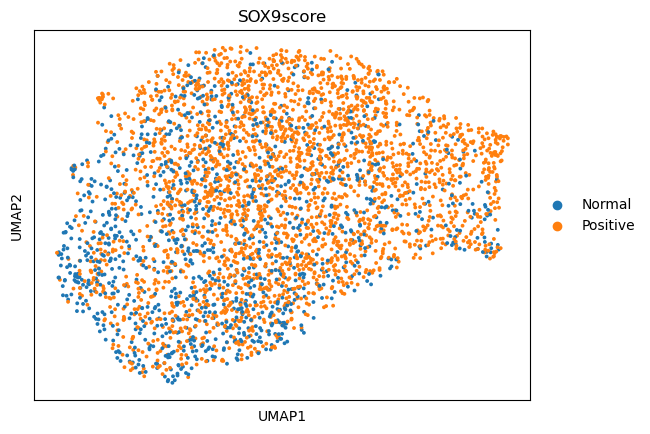

<AxesSubplot:ylabel='Count'>

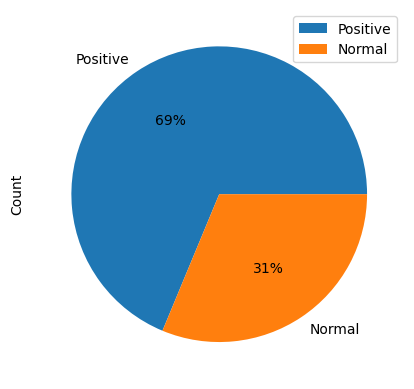

In [39]:
sox9_cells = sc.get.obs_df(ductal_cells, keys='SOX9')
sox9_pos = sox9_cells[sox9_cells>0.25]
sox9_passing = sox9_pos.index.tolist()
ductal_cells.obs['SOX9score'] = 'Normal'
ductal_cells.obs.loc[sox9_passing, 'SOX9score'] = 'Positive'

sc.pl.umap(ductal_cells, color=["SOX9score"])
category = ductal_cells.obs['SOX9score'].value_counts()
sox9df = pd.DataFrame({'Category': category.index, 'Count': category.values})
sox9df.plot.pie(y='Count', labels=sox9df['Category'], autopct='%1.0f%%')

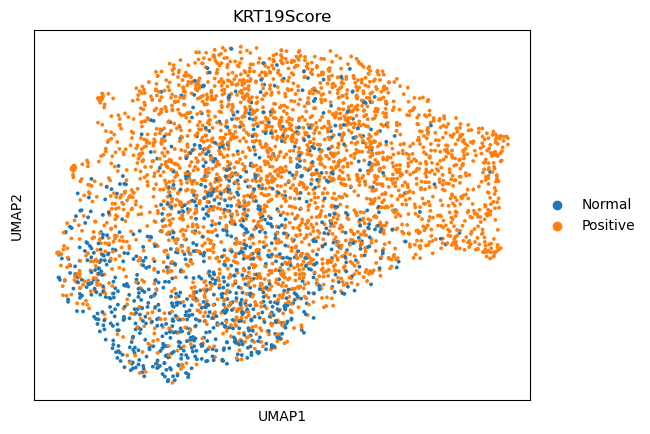

<AxesSubplot:ylabel='Count'>

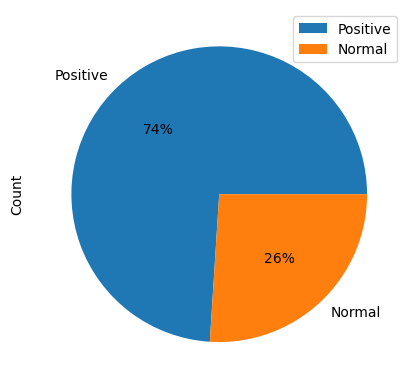

In [40]:
krt19 = sc.get.obs_df(ductal_cells, keys='KRT19')
krt19_pos = krt19[krt19>0.0]
krt19_pass = krt19_pos.index.tolist()
ductal_cells.obs['KRT19Score'] = 'Normal'
ductal_cells.obs.loc[krt19_pass, 'KRT19Score'] = 'Positive'

sc.pl.umap(ductal_cells, color=["KRT19Score"])
category = ductal_cells.obs['KRT19Score'].value_counts()
krt19df = pd.DataFrame({'Category': category.index, 'Count': category.values})
krt19df.plot.pie(y='Count', labels=krt19df['Category'], autopct='%1.0f%%')

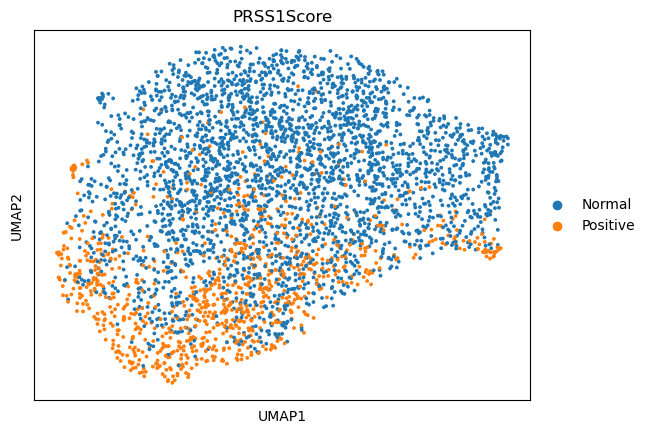

<AxesSubplot:ylabel='Count'>

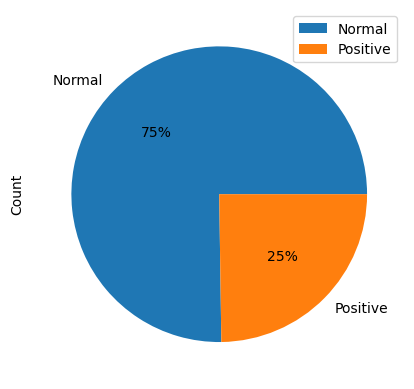

In [41]:
prss1 = sc.get.obs_df(ductal_cells, keys='PRSS1')
prss1_pos = prss1[prss1>0.0]
prss1_pass = prss1_pos.index.tolist()
ductal_cells.obs['PRSS1Score'] = 'Normal'
ductal_cells.obs.loc[prss1_pass, 'PRSS1Score'] = 'Positive'

sc.pl.umap(ductal_cells, color=["PRSS1Score"])
category = ductal_cells.obs['PRSS1Score'].value_counts()
prss1df = pd.DataFrame({'Category': category.index, 'Count': category.values})
prss1df.plot.pie(y='Count', labels=prss1df['Category'], autopct='%1.0f%%')

Ductal cells are reclustered to compare clusters for differential gene expression.  Steps below are a replica of earlier steps performed on entire dataset.

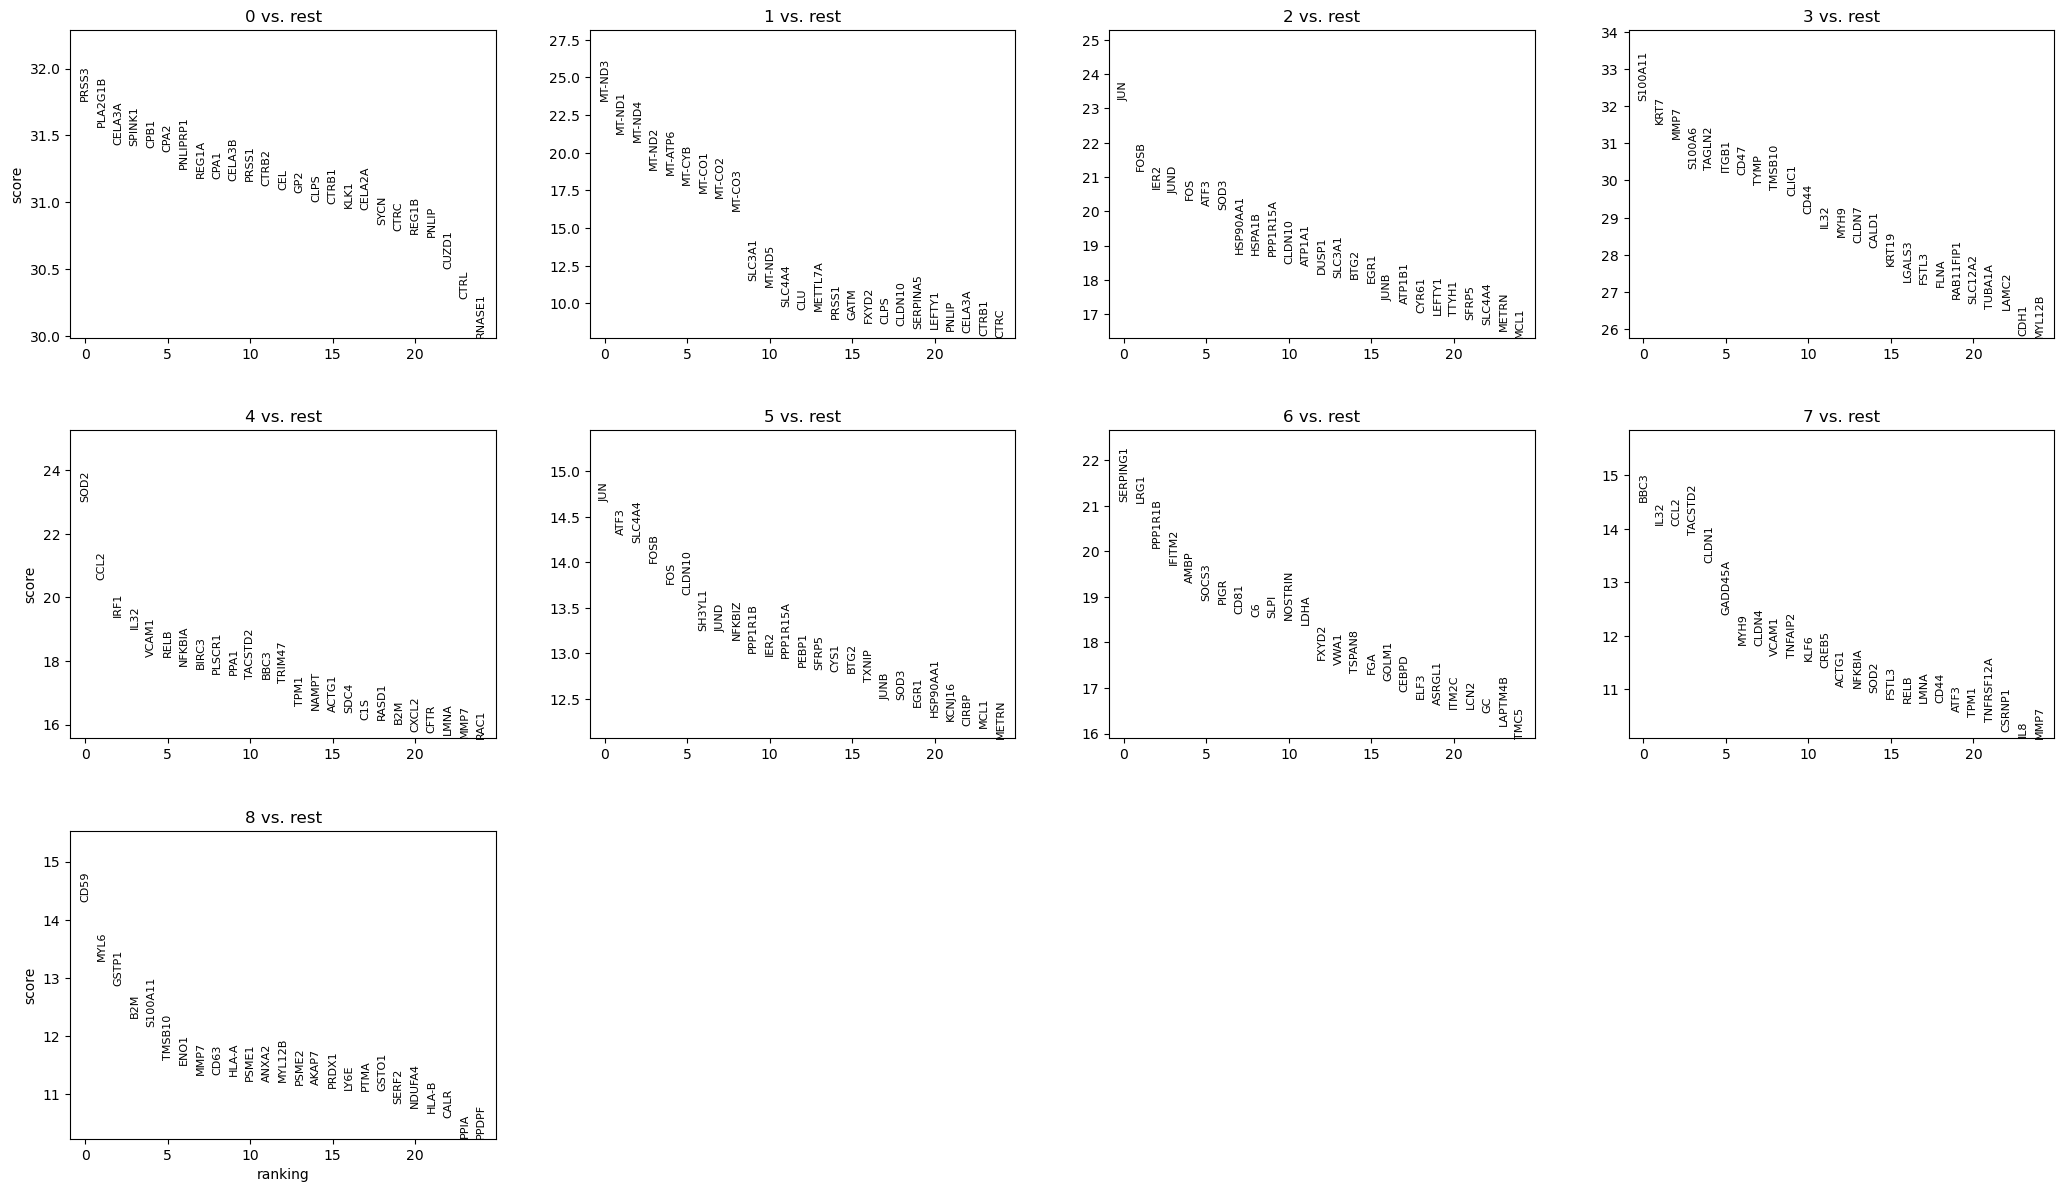

In [42]:
sc.tl.rank_genes_groups(ductal_cells, "louvain", method='wilcoxon')
sc.pl.rank_genes_groups(ductal_cells, n_genes=25, sharey=False)

In [43]:
result = ductal_cells.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(15)

0_n            0_p      1_n            1_p       2_n            2_p  \
0      PRSS3  2.493317e-221   MT-ND3  2.072878e-121       JUN  3.158009e-119   
1    PLA2G1B  1.028456e-218   MT-ND1  2.825566e-100      FOSB   1.026453e-99   
2     CELA3A  7.838004e-217   MT-ND4   1.719347e-95      IER2   1.000190e-94   
3     SPINK1  9.849117e-217   MT-ND2   1.381518e-79      JUND   1.834967e-93   
4       CPB1  1.644788e-216  MT-ATP6   7.094536e-77       FOS   6.840058e-92   
5       CPA2  3.816392e-216   MT-CYB   2.701100e-71      ATF3   1.563613e-90   
6   PNLIPRP1  2.284057e-214   MT-CO1   2.664351e-67      SOD3   2.554387e-89   
7      REG1A  1.583363e-213   MT-CO2   6.079758e-65  HSP90AA1   1.575016e-78   
8       CPA1  2.232244e-213   MT-CO3   1.134865e-58    HSPA1B   1.945787e-78   
9     CELA3B  3.225178e-213   SLC3A1   1.443911e-30  PPP1R15A   3.531743e-78   
10     PRSS1  3.699823e-213   MT-ND5   1.186935e-28    CLDN10   3.440333e-76   
11     CTRB2  1.000817e-212   SLC4A4   1.017895e-22    ATP1A1   1.110864e-75   
12       CEL  2.537284e-212      CLU   1.049536e-21     DUSP1   7.223870e-74   
13       GP2  4.890325e-212  METTL7A   1.830570e-21    SLC3A1   6.171021e-73   
14      CLPS  4.501847e-211    PRSS1   3.341347e-19      BTG2   1.077109e-72   

        3_n            3_p      4_n            4_p       5_n           5_p  \
0   S100A11  1.366849e-226     SOD2  3.301360e-117       JUN  1.020245e-48   
1      KRT7  2.471187e-218     CCL2   6.017289e-94      ATF3  1.965026e-46   
2      MMP7  1.257855e-212     IRF1   7.978083e-84    SLC4A4  7.376984e-46   
3    S100A6  5.330031e-202     IL32   1.181820e-80      FOSB  1.704270e-44   
4    TAGLN2  1.596213e-201    VCAM1   1.678388e-73       FOS  4.019616e-43   
5     ITGB1  1.014137e-200     RELB   1.735757e-73    CLDN10  2.026735e-42   
6      CD47  7.147496e-200   NFKBIA   2.167837e-71    SH3YL1  4.521787e-40   
7      TYMP  1.996522e-196    BIRC3   1.233823e-70      JUND  5.159657e-40   
8    TMSB10  1.857927e-194   PLSCR1   2.192900e-69    NFKBIZ  1.691305e-39   
9     CLIC1  2.559687e-192     PPA1   3.998821e-69   PPP1R1B  1.182374e-38   
10     CD44  2.296732e-186  TACSTD2   3.400995e-68      IER2  1.689928e-38   
11     IL32  1.963681e-181     BBC3   4.431354e-68  PPP1R15A  2.212586e-38   
12     MYH9  1.448094e-178   TRIM47   4.131281e-67     PEBP1  8.523970e-38   
13    CLDN7  1.474608e-176     TPM1   6.127735e-62     SFRP5  1.177910e-37   
14    CALD1  7.021849e-175    NAMPT   4.704362e-61      CYS1  1.607611e-37   

         6_n           6_p      7_n           7_p      8_n           8_p  
0   SERPING1  9.164859e-99     BBC3  9.952783e-48     CD59  1.981284e-46  
1       LRG1  1.689736e-98     IL32  4.936633e-45     MYL6  2.245874e-40  
2    PPP1R1B  1.138831e-89     CCL2  6.528585e-45    GSTP1  7.766078e-38  
3     IFITM2  1.551074e-86  TACSTD2  7.468986e-44      B2M  7.481326e-35  
4       AMBP  4.854427e-83    CLDN1  8.893258e-41  S100A11  5.293867e-34  
5      SOCS3  9.368181e-80  GADD45A  2.779547e-35   TMSB10  5.006193e-31  
6       PIGR  2.616245e-79     MYH9  2.238238e-32     ENO1  1.260902e-30  
7       CD81  1.817383e-77    CLDN4  3.109453e-32     MMP7  9.185177e-30  
8         C6  7.344186e-77    VCAM1  2.563591e-31     CD63  9.289015e-30  
9       SLPI  7.965034e-77  TNFAIP2  4.401981e-31    HLA-A  1.162388e-29  
10   NOSTRIN  1.706095e-76     KLF6  7.835426e-31    PSME1  2.875693e-29  
11      LDHA  1.402858e-75    CREB5  3.677466e-30    ANXA2  3.484706e-29  
12     FXYD2  1.503937e-69    ACTG1  2.041755e-28   MYL12B  4.034745e-29  
13      VWA1  9.745238e-69   NFKBIA  2.787325e-28    PSME2  6.511484e-29  
14    TSPAN8  2.965194e-67     SOD2  7.820202e-28    AKAP7  7.273599e-29

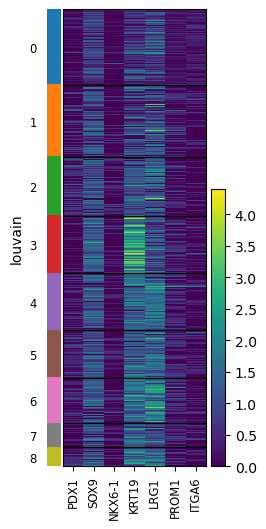

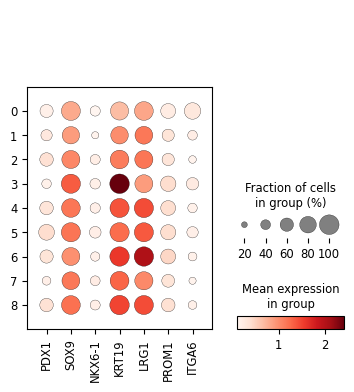

In [44]:
ductalgenes = ["PDX1", "SOX9", "NKX6-1", "KRT19", "LRG1", "PROM1", "ITGA6"]
sc.pl.heatmap(ductal_cells, var_names = ductalgenes ,groupby = "louvain")
sc.pl.dotplot(ductal_cells, ductalgenes, groupby = 'louvain')

In [45]:
TP_marker = ["SOX9","PDX1","NKX6-1"]
clusters = [adata, ductal_cells]
for x in clusters: 
    sc.tl.score_genes(x, TP_marker)
    tp_score = sc.get.obs_df(x, keys='score')
    high_scoring = tp_score[tp_score > 0.25]
    passing = high_scoring.index.tolist()
    x.obs['triple_positive'] = 'Normal'
    x.obs.loc[passing, 'triple_positive'] = 'TP'

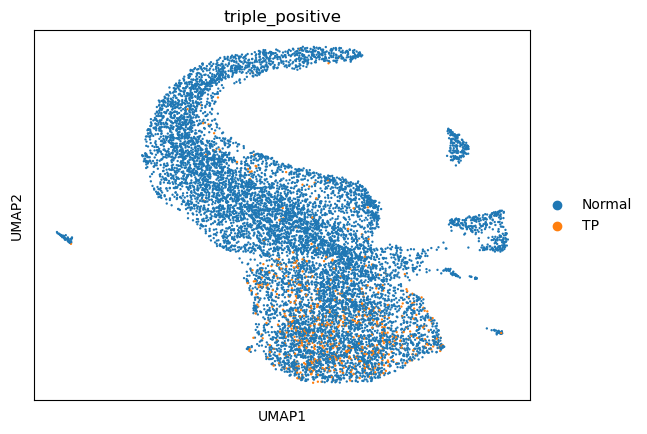

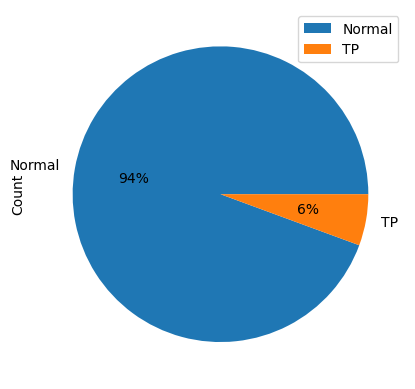

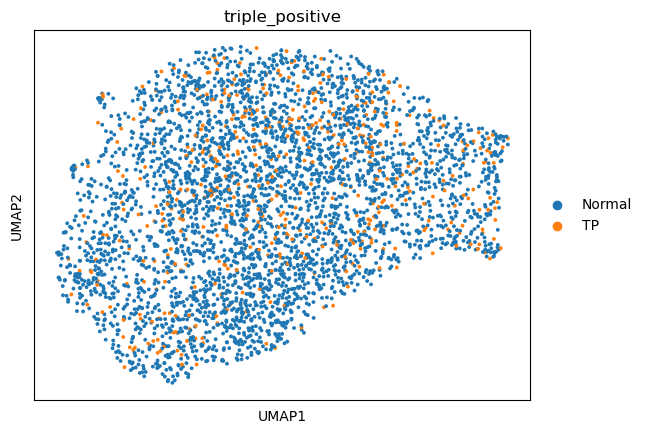

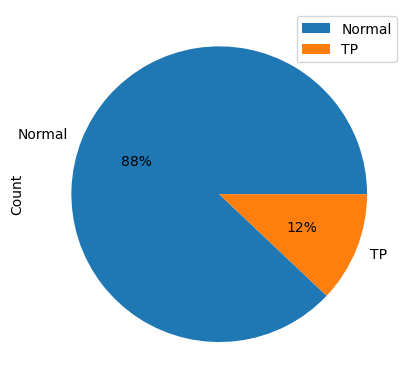

In [46]:
for x in clusters:
    sc.pl.umap(x, color=["triple_positive"])
    category_counts = x.obs['triple_positive'].value_counts()
    dataframe = pd.DataFrame({'Category': category_counts.index, 'Count': category_counts.values})
    dataframe.plot.pie(y='Count', labels=dataframe['Category'], autopct='%1.0f%%')

## Heatmap and dotplot of genes of interest for potential identification as progenitor like cells.

In [47]:
ductal_clusterid = ["ductal1", "ductal2", "ductal3", "DP", "ductal4", "TP"]
ductal_cells.rename_categories('louvain', ductal_clusterid)

ValueError: new categories need to have the same number of items as the old categories!

Clusters remamed based on assumed identity.

In [ ]:
sc.pl.umap(ductal_cells, color="louvain")

## UMAP of ductal cells with labeled double positive PROM1 ITGA6 and triple positive PDX1 SOX9 NKX6-1

In [ ]:
ductal_cells.obs['new_clusters'] = (
    ductal_cells.obs["louvain"]
    .map(lambda x: {"ductal1": "ductal", "ductal2": "ductal", "ductal3": "ductal", "ductal4": "ductal"}.get(x, x))
    .astype("category")
)

In [ ]:
sc.pl.umap(ductal_cells, color="new_clusters")
sc.pl.dotplot(ductal_cells, genes, groupby = 'new_clusters')

## UMAP of cells after clusters are combined

In [ ]:
#adata.write(results_file, compression='gzip')# `compression='gzip'` saves disk space, but slows down writing and subsequent reading
ductal_cells.X = ductal_cells.layers['raw_counts']
#del ductal_cells.layers['raw_counts']
#ductal_cells.write(ductal_file, compression='gzip')

Write adata to .h5ad file to share with others who wish to use the dataset for visualization or further analysis.
Ductal cell matrix is returned to raw counts for stemID analysis.  To keep scaled and normalized data simply delete the two lines preceding the write of the ductal file.

In [ ]:
import datatable as dt
X = pd.DataFrame(ductal_cells.X.toarray().T,columns=ductal_cells.obs_names)
Symbol=dt.Frame({'Symbol':ductal_cells.var_names.values})
X = dt.cbind([Symbol,dt.Frame(X)])
X.to_csv('duct_count.csv')

Raw read matrix is extracted as a csv for use in R for easier compatability.

# Analysis:

After performing PCA and UMAP on the dataset to subset the ductal cells based on marker gene expression, it is possible to run StemID analysis on the ductal population to interpolate the possible locations of stem cells within the cluster.  This has to be done in R due to the limitations of Anaconda and github based packages such as RaceID.  This is why we have produced the raw count csv file duct_count.

After StemID processing, it appears that the progenitor-like cells when compared only within the ductal clusters are actually marked as low scoring when compared to its neighbors.  This may be due to the relatively larger transciptomic differences between the progenitor like cells and the ductal cells, which reduces the number of links generated between the clusters.

In terms of stemID enrichment, there was a considerable proportion of enriched clusters detected by the stemID.  This may point to a greater proportion of stem cells being located in the ductal portion of the pancreas but would require further study and comparison of the other cell compartments.

Further improvements could be made such as using more markers to identify ductal genes, as well as identifying Double Postive and Triple Positive cells using a more rigorous method such as by log2FC expression.  It is possible that once the improvements to filtering are made, there may be a more clear trend noticed among the expression of the progenitor like cells and their stemID prediction.

# Conclusion

In conclusion, the clustering and stemID analysis were successfully performed on the dataset starting from scanpy from Python.  The goal of this project was to replicate an analysis originally performed in R using Seurat and reproduce the results using the scanpy library in Python.  However, due to the unique availability of stemID in the R environment, it becomes necessary to use R at least for the stemID analysis of the dataset.  If there were an alternative method found that is compatible with Python, this could serve as a workaround to the limitation.

In the future I expect the conversion between scanpy and Seurat to improve as both libraries are becoming increasingly common to use among bioinformaticians in the field.  Certain steps I had to perform to export and conserve raw counts may become unnecessary as default api settings change to capture these fields automatically.